# Phenolopy

## Load packages

### Set up a dask cluster

In [1]:
%matplotlib inline
%load_ext autoreload

import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import datacube
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter, wiener
from scipy.stats import zscore
from statsmodels.tsa.seasonal import STL as stl
from datacube.drivers.netcdf import write_dataset_to_netcdf

sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('./scripts')
import phenolopy

In [2]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:46505 Dashboard: /user/lewis/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [3]:
# open up a datacube connection
dc = datacube.Datacube(app='phenolopy')

## Study area and data setup

### Set study area and time range

In [4]:
# set lat, lon (y, x) dictionary of testing areas for gdv project
loc_dict = {
    'yan_full':   (-22.750, 119.10),
    'yan_full_1': (-22.725, 119.05),
    'yan_full_2': (-22.775, 119.15),
    'roy_sign_1': (-22.618, 119.989),
    'roy_full':   (-22.555, 120.01),
    'roy_full_1': (-22.487, 119.927),
    'roy_full_2': (-22.487, 120.092),
    'roy_full_3': (-22.623, 119.927),
    'roy_full_4': (-22.623, 120.092),
    'oph_full':   (-23.280432, 119.859309),
    'oph_full_1': (-23.375319, 119.859309),
    'oph_full_2': (-23.185611, 119.859309),
    'oph_full_3': (-23.233013, 119.859309),
    'oph_full_4': (-23.280432, 119.859309),
    'oph_full_5': (-23.327867, 119.859309),
    'test':       (-31.6069288, 116.9426373)
}

# set buffer length and height (x, y)
buf_dict = {
    'yan_full':   (0.15, 0.075),
    'yan_full_1': (0.09, 0.025),
    'yan_full_2': (0.05, 0.0325),
    'roy_sign_1': (0.15, 0.21),
    'roy_full':   (0.33, 0.27),
    'roy_full_1': (0.165209/2, 0.135079/2),
    'roy_full_2': (0.165209/2, 0.135079/2),
    'roy_full_3': (0.165209/2, 0.135079/2),
    'roy_full_4': (0.165209/2, 0.135079/2),
    'oph_full':   (0.08, 0.11863),
    'oph_full_1': (0.08, 0.047452/2),
    'oph_full_2': (0.08, 0.047452/2),
    'oph_full_3': (0.08, 0.047452/2),
    'oph_full_4': (0.08, 0.047452/2),
    'oph_full_5': (0.08, 0.047452/2),
    'test':       (0.05, 0.05)
}

In [5]:
# select location from dict
study_area = 'roy_full_2'

# set buffer size in lon, lat (x, y)
lon_buff, lat_buff = buf_dict[study_area][0], buf_dict[study_area][1]

# select time range. for a specific year, set same year with month 01 to 12. multiple years will be averaged.
time_range = ('2016-11', '2018-02')

In [6]:
# select a study area from existing dict
lat, lon = loc_dict[study_area][0], loc_dict[study_area][1]

# combine centroid with buffer to form study boundary
lat_extent = (lat - lat_buff, lat + lat_buff)
lon_extent = (lon - lon_buff, lon + lon_buff)

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

### Load sentinel-2a, b data for above parameters


In [7]:
# set measurements (bands)
measurements = [
    'nbart_blue',
    'nbart_green',
    'nbart_red',
    'nbart_nir_1',
    'nbart_swir_2'
]

# create query from above and expected info
query = {
    'x': lon_extent,
    'y': lat_extent,
    'time': time_range,
    'measurements': measurements,
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10),
    'group_by': 'solar_day',
}

# load sentinel 2 data
ds = load_ard(
    dc=dc,
    products=['s2a_ard_granule', 's2b_ard_granule'],
    min_gooddata=0.90,
    dask_chunks={'time': 1},
    **query
)

# display dataset
print(ds)

# display a rgb data result of temporary resampled median 
#rgb(ds.resample(time='1M').median(), bands=['nbart_red', 'nbart_green', 'nbart_blue'], col='time', col_wrap=12)

../Scripts/dea_datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 31 out of 47 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 31 time steps as a dask array
<xarray.Dataset>
Dimensions:       (time: 31, x: 1819, y: 1660)
Coordinates:
  * time          (time) datetime64[ns] 2016-11-05T02:04:42.026000 ... 2018-0...
  * y             (y) float64 -2.47e+06 -2.47e+06 ... -2.486e+06 -2.486e+06
  * x             (x) float64 -1.222e+06 -1.222e+06 ... -1.204e+06 -1.204e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>
    nbart_green   (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>
    nbart_red     (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>
    nbart_nir_1   (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>
    nbart_s

### Conform DEA band names

In [8]:
# takes our dask ds and conforms (renames) bands
ds = phenolopy.conform_dea_band_names(ds)

# display dataset
print(ds)

Conforming satellite bands
> Satellite band names conformed successfully.

<xarray.Dataset>
Dimensions:      (time: 31, x: 1819, y: 1660)
Coordinates:
  * time         (time) datetime64[ns] 2016-11-05T02:04:42.026000 ... 2018-02...
  * y            (y) float64 -2.47e+06 -2.47e+06 ... -2.486e+06 -2.486e+06
  * x            (x) float64 -1.222e+06 -1.222e+06 ... -1.204e+06 -1.204e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


### Calculate vegetation index

In [9]:
# takes our dask ds and calculates veg index from spectral bands
ds = phenolopy.calc_vege_index(ds, index='mavi', drop=True)

# display dataset
print(ds)

Generating vegetation index: mavi
> Drop bands set to True. Dropping these bands: ['blue', 'green', 'red', 'nir', 'swir1']
> Vegetation index calculated successfully.

<xarray.Dataset>
Dimensions:      (time: 31, x: 1819, y: 1660)
Coordinates:
  * time         (time) datetime64[ns] 2016-11-05T02:04:42.026000 ... 2018-02...
  * y            (y) float64 -2.47e+06 -2.47e+06 ... -2.486e+06 -2.486e+06
  * x            (x) float64 -1.222e+06 -1.222e+06 ... -1.204e+06 -1.204e+06
    spatial_ref  int32 3577
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


## Pre-processing phase

### Temporary - load MODIS dataset

In [ ]:
#ds = phenolopy.load_test_dataset(data_path='./data/')

In [ ]:
# resample to bimonth
ds = phenolopy.resample(ds, interval='1M', reducer='median')

In [ ]:
# interp
ds = ds.chunk({'time': -1})
ds = phenolopy.interpolate(ds=ds, method='interpolate_na')

In [ ]:
# drop years
ds = ds.where(ds['time.year'] == 2017, drop=True)

### Group data by month and reduce by median

In [10]:
# take our dask ds and group and reduce dataset in median weeks (26 for one year)
ds = phenolopy.group(ds, group_by='month', reducer='median')

# display dataset
print(ds)

Group dataset interval: month via reducer: median
> Selecting year: 2017 to re-label times after groupby.
> Warning: dataset contains nan values. You should interpolate nan values next.
> Group successful.

<xarray.Dataset>
Dimensions:      (time: 11, x: 1819, y: 1660)
Coordinates:
  * y            (y) float64 -2.47e+06 -2.47e+06 ... -2.486e+06 -2.486e+06
  * x            (x) float64 -1.222e+06 -1.222e+06 ... -1.204e+06 -1.204e+06
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2017-12-01
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(1, 1660, 1819), meta=np.ndarray>


In [11]:
# show times
ds = ds.compute()

### Remove outliers from dataset on per-pixel basis

In [12]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# takes our dask ds and remove outliers from data using median method
ds = phenolopy.remove_outliers(ds=ds, method='median', user_factor=2, z_pval=0.05)

# display dataset
print(ds)

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

<xarray.Dataset>
Dimensions:      (time: 11, x: 1819, y: 1660)
Coordinates:
  * y            (y) float64 -2.47e+06 -2.47e+06 ... -2.486e+06 -2.486e+06
  * x            (x) float64 -1.222e+06 -1.222e+06 ... -1.204e+06 -1.204e+06
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2017-12-01
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(8, 830, 1682), meta=np.ndarray>


### Resample dataset down to bi-monthly medians

In [13]:
# takes our dask ds and resamples data to bi-monthly medians
ds = phenolopy.resample(ds, interval='1W', reducer='median')

# display dataset
print(ds)

Resampling dataset interval: 1W via reducer: median
> Warning: dataset contains nan values. You should interpolate nan values next.
> Resample successful.

<xarray.Dataset>
Dimensions:      (time: 49, x: 1819, y: 1660)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01 2017-01-08 ... 2017-12-03
  * y            (y) float64 -2.47e+06 -2.47e+06 ... -2.486e+06 -2.486e+06
  * x            (x) float64 -1.222e+06 -1.222e+06 ... -1.204e+06 -1.204e+06
    spatial_ref  int32 3577
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(5, 1660, 1819), meta=np.ndarray>


### Interpolate missing (i.e. nan) values linearly

In [14]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# takes our dask ds and interpolates missing values
ds = phenolopy.interpolate(ds=ds, method='interpolate_na')

# display dataset
print(ds)

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

<xarray.Dataset>
Dimensions:      (time: 49, x: 1819, y: 1660)
Coordinates:
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2017-01-01 2017-01-08 ... 2017-12-03
  * y            (y) float64 -2.47e+06 -2.47e+06 ... -2.486e+06 -2.486e+06
  * x            (x) float64 -1.222e+06 -1.222e+06 ... -1.204e+06 -1.204e+06
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(49, 1660, 1819), meta=np.ndarray>


### Smooth data on per-pixel basis

In [15]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# take our dask ds and smooth using savitsky golay filter
ds = phenolopy.smooth(ds=ds, method='savitsky', window_length=3, polyorder=1)

# display dataset
print(ds)

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.

<xarray.Dataset>
Dimensions:      (time: 49, x: 1819, y: 1660)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01 2017-01-08 ... 2017-12-03
  * y            (y) float64 -2.47e+06 -2.47e+06 ... -2.486e+06 -2.486e+06
  * x            (x) float64 -1.222e+06 -1.222e+06 ... -1.204e+06 -1.204e+06
    spatial_ref  int32 dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(49, 1660, 1819), meta=np.ndarray>


### Upper envelope correction
todo

In [ ]:
# todo

### Calculate number of seasons 

In [16]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# take our dask ds and smooth using savitsky golay filter
da_num_seasons = phenolopy.calc_num_seasons(ds=ds)

# display dataset
print(da_num_seasons)

Beginning calculation of number of seasons.
> Calculating number of seasons.
> Success!

<xarray.DataArray 'num_seasons' (y: 1660, x: 1819)>
dask.array<transpose, shape=(1660, 1819), dtype=int16, chunksize=(1660, 1819), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 -2.47e+06 -2.47e+06 ... -2.486e+06 -2.486e+06
  * x            (x) float64 -1.222e+06 -1.222e+06 ... -1.204e+06 -1.204e+06
    spatial_ref  int32 dask.array<chunksize=(), meta=np.ndarray>


## Calculate Phenolometrics

In [17]:
# compute
ds = ds.compute()
print(ds)

<xarray.Dataset>
Dimensions:      (time: 49, x: 1819, y: 1660)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01 2017-01-08 ... 2017-12-03
  * y            (y) float64 -2.47e+06 -2.47e+06 ... -2.486e+06 -2.486e+06
  * x            (x) float64 -1.222e+06 -1.222e+06 ... -1.204e+06 -1.204e+06
    spatial_ref  int32 3577
Data variables:
    veg_index    (time, y, x) float32 0.095976375 0.102590576 ... 0.096259


In [18]:
%autoreload

# calc phenometrics via phenolopy!
ds_phenos = phenolopy.calc_phenometrics(da=ds['veg_index'], peak_metric='pos', base_metric='vos', method='seasonal_amplitude', factor=0.2, thresh_sides='two_sided', abs_value=0.1)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> Success!

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and times.
> Calculating start of season (sos) values via method: seasonal_amplitude.
> Calculating start of season (sos) times via method: seasonal_amplitude.
> Success!



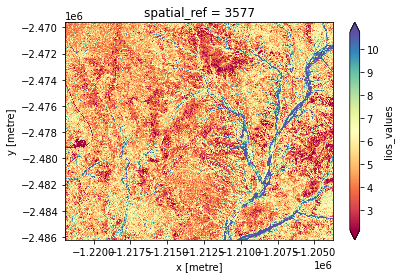

In [19]:
# set the metric you want to view
metric_name = 'lios_values'

# plot this on map
ds_phenos[metric_name].plot(robust=True, cmap='Spectral')

In [ ]:
from datacube.drivers.netcdf import write_dataset_to_netcdf
write_dataset_to_netcdf(ds_phenos, 'roy_2017_1w_phenos.nc')

### Testing

In [ ]:
# set up params
import random
import shutil

# set output filename
filename = 'roy_2_p_pos_b_vos_seas_amp_f_015'

# set seed 
random.seed(50)

# gen random x and y lists for specified num pixels (e.g. 250 x, 250 y)
n_pixels = 200
x_list = random.sample(range(0, len(ds_phenos['x'])), n_pixels)
y_list = random.sample(range(0, len(ds_phenos['y'])), n_pixels)

In [ ]:
def run_test(ds_raw, ds_phen, filename, x_list, y_list):
    
    # loop through each pixel pair
    for x, y in zip(x_list, y_list):
        
        # get pixel and associate phenos pixel
        v = ds_raw.isel(x=x, y=y)
        p = ds_phen.isel(x=x, y=y)
        
        # create fig
        fig = plt.figure(figsize=(12, 5))

        # plot main trend
        plt.plot(v['time.dayofyear'], v['veg_index'], linestyle='solid', marker='.', color='black')

        # plot pos vals and times
        plt.plot(p['pos_times'], p['pos_values'], 
                 marker='o', linestyle='', color='blue', label='POS')
        plt.annotate('POS', (p['pos_times'], p['pos_values']))

        # plot vos vals and times
        plt.plot(p['vos_times'], p['vos_values'], 
                 marker='o', linestyle='', color='darkred', label='VOS')
        plt.annotate('VOS', (p['vos_times'], p['vos_values']))

        # plot bse vals
        plt.axhline(p['bse_values'], 
                    marker='', linestyle='dashed', color='red', label='BSE')
        # add legend

        # plot sos vals and times
        plt.plot(p['sos_times'], p['sos_values'], 
                 marker='s', linestyle='', color='green', label='SOS')
        plt.annotate('SOS', (p['sos_times'], p['sos_values']))

        # plot eos vals and times
        plt.plot(p['eos_times'], p['eos_values'], 
                 marker='s', linestyle='', color='orange', label='EOS')
        plt.annotate('EOS', (p['eos_times'], p['eos_values']))

        # plot aos vals
        plt.axvline(p['pos_times'], 
                    marker='', color='magenta', linestyle='dotted', label='AOS')

        # plot los vals
        plt.axhline((p['sos_values'] + p['eos_values']) / 2, 
                    marker='', color='yellowgreen', linestyle='dashdot', label='LOS')

        # plot sios
        plt.fill_between(v['time.dayofyear'], v['veg_index'], y2=p['bse_values'],
                         color='red', alpha=0.1, label='SIOS')

        # plot lios
        t = ~v.where((v['time.dayofyear'] >= p['sos_times']) & (v['time.dayofyear'] <= p['eos_times'])).isnull()
        plt.fill_between(v['time.dayofyear'], v['veg_index'], where=t['veg_index'],
                          color='yellow', alpha=0.2, label='LIOS')    

        # plot siot
        plt.fill_between(v['time.dayofyear'], v['veg_index'], y2=p['bse_values'],
                         color='aqua', alpha=0.3, label='SIOT')

        # plot liot
        plt.fill_between(v['time.dayofyear'], v['veg_index'],
                         color='aqua', alpha=0.1, label='LIOT')

        # add legend
        plt.legend(loc='best')
        
        # create output filename
        out = os.path.join('testing', filename + '_x_' + str(x) + '_y_' + str(y) + '.jpg')

        # save to file without plotting
        fig.savefig(out)
        plt.close()
        
    # export as zip
    shutil.make_archive(filename + '.zip', 'zip', './testing')

    # clear all files in dir
    for root, dirs, files in os.walk('./testing'):
        for file in files:
            os.remove(os.path.join(root, file))

# perform test
run_test(ds_raw=ds, ds_phen=ds_phenos, filename=filename, x_list=x_list, y_list=y_list)

In [ ]:
from datacube.utils.cog import write_cog

write_cog(geo_im=ds_phenos['lios_values'], fname='lios.tif', overwrite=True)

### Working

In [ ]:
# different types of detection, using stl residuals - remove outlier method
#from scipy.stats import median_absolute_deviation

#v = ds.isel(x=0, y=0, time=slice(0, 69))
#v['veg_index'].data = data

#v_med = remove_outliers(v, method='median', user_factor=1, num_dates_per_year=24, z_pval=0.05)
#v_zsc = remove_outliers(v, method='zscore', user_factor=1, num_dates_per_year=24, z_pval=0.1)

#stl_res = stl(v['veg_index'], period=24, seasonal=5, robust=True).fit()
#v_rsd = stl_res.resid
#v_wgt = stl_res.weights

#o = v.copy()
#o['veg_index'].data = v_rsd

#w = v.copy()
#w['veg_index'].data = v_wgt

#m = xr.where(o > o.std('time'), True, False)
#o = v.where(m)

#m = xr.where(w < 1e-8, True, False)
#w = v.where(m)

#fig = plt.figure(figsize=(18, 7))
#plt.plot(v['time'], v['veg_index'], color='black', marker='o')
#plt.plot(o['time'], o['veg_index'], color='red', marker='o', linestyle='-')
#plt.plot(w['time'], w['veg_index'], color='blue', marker='o', linestyle='-')
#plt.axhline(y=float(o['veg_index'].std('time')))
#plt.show()

In [ ]:
# working method for stl outlier dection. can't quite get it to match timesat results?
# need to speed this up - very slow for even relatively small datasets
#def func_stl(vec, period, seasonal, jump_l, jump_s, jump_t):
    #resid = stl(vec, period=period, seasonal=seasonal, 
                #seasonal_jump=jump_s, trend_jump=jump_t, low_pass_jump=jump_l).fit()
    #return resid.resid

#def do_stl_apply(da, multi_pct, period, seasonal):
    
    # calc jump size for lowpass, season and trend to speed up processing
    #jump_l = int(multi_pct * (period + 1))
    #jump_s = int(multi_pct * (period + 1))
    #jump_t = int(multi_pct * 1.5 * (period + 1))
    
    #f = xr.apply_ufunc(func_stl, da,
                       #input_core_dims=[['time']], 
                       #output_core_dims=[['time']], 
                       #vectorize=True, dask='parallelized', 
                       #output_dtypes=[ds['veg_index'].dtype],
                       #kwargs={'period': period, 'seasonal': seasonal, 
                               #'jump_l': jump_l, 'jump_s': jump_s, 'jump_t': jump_t}) 
    #return f

# chunk up to make use of dask parallel
#ds = ds.chunk({'time': -1})

# calculate residuals for each vector  stl
#stl_resids = do_stl_apply(ds['veg_index'], multi_pct=0.15, period=24, seasonal=13)

#s = ds['veg_index'].stack(z=('x', 'y'))
#s = s.chunk({'time': -1})
#s = s.groupby('z').map(func_stl)
#out = out.unstack()

#s = ds.chunk({'time': -1})
#t = xr.full_like(ds['veg_index'], np.nan)
#out = xr.map_blocks(func_stl, ds['veg_index'], template=t).compute()

#stl_resids = stl_resids.compute()

In [ ]:
# working double logistic - messy though
# https://colab.research.google.com/github/1mikegrn/pyGC/blob/master/colab/Asymmetric_GC_integration.ipynb#scrollTo=upaYKFdBGEAo
# see for asym gaussian example

#da = v.where(v['time.year'] == 2016, drop=True)

#def logi(x, a, b, c, d):
    #return a / (1 + xr.ufuncs.exp(-c * (x - d))) + b

# get date at max veg index
#idx = int(da['veg_index'].argmax())

# get left and right of peak of season
#da_l = da.where(da['time'] <= da['time'].isel(time=idx), drop=True)
#da_r = da.where(da['time'] >= da['time'].isel(time=idx), drop=True)

# must sort right curve (da_r) descending to flip data
#da_r = da_r.sortby(da_r['time'], ascending=False)

# get indexes of times (times not compat with exp)
#da_l_x_idxs = np.arange(1, len(da_l['time']) + 1, step=1)
#da_r_x_idxs = np.arange(1, len(da_r['time']) + 1, step=1)

# fit curve
#popt_l, pcov_l = curve_fit(logi, da_l_x_idxs, da_l['veg_index'], method="trf")
#popt_r, pcov_r = curve_fit(logi, da_r_x_idxs, da_r['veg_index'], method="trf")

# apply fit to original data
#da_fit_l = logi(da_l_x_idxs, *popt_l)
#da_fit_r = logi(da_r_x_idxs, *popt_r)

# flip fitted vector back to original da order
#da_fit_r = np.flip(da_fit_r)

# get mean of pos value, remove overlap between l and r
#pos_mean = (da_fit_l[-1] + da_fit_r[0]) / 2
#da_fit_l = np.delete(da_fit_l, -1)
#da_fit_r = np.delete(da_fit_r, 1)

# concat back together with mean val inbetween
#da_logi = np.concatenate([da_fit_l, pos_mean, da_fit_r], axis=None)

# smooth final curve with mild savgol
#da_logi = savgol_filter(da_logi, 3, 1)

#fig = plt.subplots(1, 1, figsize=(6, 4))
#plt.plot(da['time'], da['veg_index'], 'o')
#plt.plot(da['time'], da_logi)

In [ ]:
#from scipy.signal import find_peaks

#x, y = 0, 1

#v = da.isel(x=x, y=y)

#height = float(v.quantile(dim='time', q=0.75))
#distance = math.ceil(len(v['time']) / 4)

#p = find_peaks(v, height=height, distance=distance)[0]

#p_dts = v['time'].isel(time=p)

#for p_dt in p_dts:
    #plt.axvline(p_dt['time'].dt.dayofyear, color='black', linestyle='--')

#count_peaks = len(num_peaks[0])
#if count_peaks > 0:
    #return count_peaks
#else:
    #return 0
    
#plt.plot(v['time.dayofyear'], v)

In [ ]:
# flip to get min closest to pos
# if we want closest sos val to pos we flip instead to trick argmin
#flip = dists_sos_v.sortby(dists_sos_v['time'], ascending=False)
#min_right = flip.isel(time=flip.argmin('time'))
#temp_pos_cls = da.isel(x=x, y=0).where(da['time'] == min_right['time'].isel(x=x, y=0))
#plt.plot(temp_pos_cls.time, temp_pos_cls, marker='o', color='black', alpha=0.25)